# Prequisite

## Libraries

In [98]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import PIL
from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report

torch.manual_seed(42)
np.random.seed(42)
cv2.setRNGSeed(42)

In [45]:
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

PyTorch version: 2.1.0
torchvision version: 0.16.0


In [46]:
ROOT = '../../dataset/v1'

In [47]:
# Uncomment if trained on GCP
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Uncomment if trained locally
device = torch.device("mps")
print(device)

mps


In [48]:
MOD_DICT = {
    1: 'EfficientNet'
    , 2: 'MobileNet'
    , 3: 'ShuffleNet'
}

## Dataset

### Dataset Class and Functions

In [49]:
def crop_face(image_path, target_width=300, target_height=400):
    """
    Crop and resize the detected face in an image.

    Parameters:
    - image_path (str): The path to the input image file.
    - target_width (int, optional): The desired width of the output face image (default is 300 pixels).
    - target_height (int, optional): The desired height of the output face image (default is 400 pixels).

    Returns:
    - resized_rgb (numpy.ndarray): The cropped and resized face region as a NumPy array in Gray color format.
    - resized_gray (numpy.ndarray): The cropped and resized face region as a NumPy array in Gray color format.

    Raises:
    - ValueError: If the image cannot be loaded from the given path or if no faces are detected in the image.

    This function takes an image file, detects the face in the image, and resizes it to match the specified target 
    width and height while maintaining the aspect ratio. The result is returned as a NumPy array in RGB and Gray color format.

    Example usage:
    >>> original_image, gray_iamge = crop_face("your_image.jpg")
    """

    image = cv2.imread(image_path)
    image_rb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Search for faces on the image.
    face_cascade = cv2.CascadeClassifier("../../haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)
    x, y, w, h = faces[0]

    # Adjust height, so it will create a 3:4 (width:height) ratio.
    exp_ratio = 3 / 4
    h = int(w / exp_ratio)

    # Adjust y, as a pre-caution if it 
    # being cropped below the forehead.
    y -= int((image.shape[0] / target_height) * 35)
    
    # Add padding for the height, as a pre-caution
    # if it being cropped below the forehead.
    if y + h > image.shape[0]:
        minus_y = y + h - image.shape[0]
        y -= minus_y

    image_cropped = image_rb[y:y+h, x:x+w]
    image_cropped_resized = cv2.resize(image_cropped, (target_width, target_height))
    
    resized_rgb = image_cropped_resized
    resized_gray = cv2.cvtColor(resized_rgb, cv2.COLOR_BGR2GRAY)

    return resized_rgb, resized_gray

In [50]:
class CustomDataset(Dataset):
    """
    Custom PyTorch dataset for working with image data and labels stored in a DataFrame.

    Parameters:
    - dataframe (pandas.DataFrame): The DataFrame containing image file paths and corresponding labels.
    - root (str): The root directory where the image files are located.
    - transform (callable, optional): A function/transform to apply to the images (e.g., data augmentation).

    Attributes:
    - dataframe (pandas.DataFrame): The input DataFrame containing image file paths and labels.
    - root (str): The root directory where image files are stored.
    - transform (callable, optional): A function/transform to be applied to the images.

    Methods:
    - __len__(): Returns the number of samples in the dataset.
    - __getitem__(idx): Returns the image and label for the specified index.

    This dataset class is designed to work with image data stored in a DataFrame, where each row contains
    a file path to an image and its corresponding label. It allows for data loading, cropping, and optional
    data transformation using PyTorch's data loading utilities. 

    Example usage:
    >>> dataset = CustomDataset(dataframe, root_dir, transform=transforms.Compose([transforms.Resize(256), transforms.ToTensor()]))
    >>> dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    >>> for images, labels in dataloader:
    >>>     # Process the batch of images and labels
    """

    def __init__(self, dataframe, root, transform):
        self.dataframe = dataframe
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.dataframe.iloc[idx, 0])
        image, _ = crop_face(img_path)
        image = Image.fromarray(image)
        
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform: 
            image = self.transform(image)

        return image, label

### Processes

In [51]:
df = pd.read_excel('../../dataset/df_cls.xlsx')
df.dropna()
df.head()

,nama,tampak_depan_root,full_depan,tampak_samping_root,full_samping,tampak_senyum_root,full_senyum,tipe,simetris,seimbang,transversal,profil,nasolabial,mentolabial,segaris,bukal,kurva,garis
0,aisyahi,tampak_depan,tampak_depan/aisyahi.jpg,tampak_samping,tampak_samping/aisyahi.jpg,tampak_senyum,tampak_senyum/aisyahi.jpg,doliko,asimetris,tidak,tidak,cekung,normal,lebar,ya,lebar,datar,tinggi
1,alfira,tampak_depan,tampak_depan/alfira.jpg,tampak_samping,tampak_samping/alfira.jpg,tampak_senyum,tampak_senyum/alfira.jpg,doliko,simetris,ya,ya,cembung,tajam,tumpul,ya,sedang,konsonan,rendah
2,despasya,tampak_depan,tampak_depan/despasya.jpg,tampak_samping,tampak_samping/despasya.jpg,tampak_senyum,tampak_senyum/despasya.jpg,doliko,simetris,ya,tidak,cembung,tajam,tumpul,ya,lebar,datar,sedang
3,galuh,tampak_depan,tampak_depan/galuh.jpg,tampak_samping,tampak_samping/galuh.jpg,tampak_senyum,tampak_senyum/galuh.jpg,doliko,simetris,ya,ya,cekung,tajam,tumpul,ya,leabar,konsonan,tinggi
4,happy,tampak_depan,tampak_depan/happy.jpg,tampak_samping,tampak_samping/happy.jpg,tampak_senyum,tampak_senyum/happy.jpg,brachy,simetris,ya,tidak,cembung,normal,tumpul,tidak,sedang,datar,rendah


In [52]:
TASKS = [
    'tipe', 'simetris', 'seimbang', 'transversal'
    , 'profil', 'nasolabial', 'mentolabial', 'segaris'
    , 'bukal', 'kurva', 'garis'
]
df_tasks_dict = {}

for task in TASKS:
    if task in ['tipe', 'seimbang', 'simetris', 'transversal']:
        df_tasks_dict[task] = df[['full_depan', task]]
    elif task in ['profil', 'nasolabial', 'mentolabial']:
        df_tasks_dict[task] = df[['full_samping', task]]
    else: df_tasks_dict[task] = df[['full_senyum', task]]

In [53]:
desired_size = (300, 400)

train_transform = T.Compose([
    T.Resize(desired_size),
    T.ToTensor()
])

val_transform = T.Compose([
    T.Resize(desired_size),
    T.ToTensor()
])

# Helper Function(s)

In [54]:
class FKGTask:
    """
    Designed to handle and prepare data for classification tasks. 
    It provides methods to encode categorical labels, split data into training and validation sets, 
    and retrieve the encoded data, making it useful for machine learning tasks.

    Parameters:
    - face_side (str): The column name representing the face side in the dataset.
    - subtask (str): The column name representing the subtask or label in the dataset.
    - dataframe (pd.DataFrame): The Pandas DataFrame containing the encoded data.

    Attributes:
    - face_side (str): The column name representing the face side in the dataset.
    - subtask (str): The column name representing the subtask or label in the dataset.
    - dataframe (pd.DataFrame): The Pandas DataFrame containing the encoded data.
    - encoding_dict (dict): A dictionary that maps the original class labels to their encoded values.
    - X (pd.Series): The feature data (independent variable).
    - y (pd.Series): The target data (dependent variable).

    Methods:
    - __init__(self, face_side, subtask, data): Initializes an instance of the FKGTask class.
    - _get_dataframe(self, data, subtask): Encodes the categorical labels in the dataset and returns the encoded DataFrame and encoding dictionary.
    - _get_x_and_y(self): Extracts the feature and target data from the DataFrame.
    - get_train_test_split(self): Splits the data into training and validation sets and returns them as DataFrames.

    Example Usage:
    >>> fkg_task = FKGTask(face_side=`face_side`, subtask=`subtask`, data=my_data)
    >>> train_data, val_data = fkg_task.get_train_test_split()
    
    >>>  # Train a machine learning model using the train_data
    >>>  # Validate the model using the val_data

    Note:
    - This class is designed to work with Pandas DataFrames and assumes that the input data contains columns corresponding to the specified `face_side` and `subtask`.
    - It uses ordinal encoding to convert categorical labels into numerical values.
    - The class provides a convenient way to split the data into training and validation sets, maintaining the stratified distribution of the target variable.
    """

    def __init__(self, face_side, subtask, data):
        self.face_side = face_side
        self.subtask = subtask
        self.dataframe, self.encoding_dict = self._get_dataframe(data, self.subtask)
        self.X, self.y = self._get_x_and_y()

    def _get_dataframe(self, data, subtask):
        encoder = OrdinalEncoder()
        unique_values = data[subtask][subtask].unique().reshape(-1, 1)
        encoder.fit(unique_values)

        before_val = data[subtask][subtask]
        data[subtask][subtask] = encoder.transform(data[subtask][subtask].values.reshape(-1, 1))
        encoding_dict = {original_class: encoded_value for original_class, encoded_value in zip(data[subtask][subtask], before_val)}
        encoding_dict = {v: k for k, v in encoding_dict.items()}
        
        return data[subtask], encoding_dict

    def _get_x_and_y(self):
        X = self.dataframe[self.face_side]
        y = self.dataframe[self.subtask]

        return X, y

    def get_train_test_split(self):
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y
            , stratify=self.y
            , test_size=0.2
            , random_state=42
        )

        return pd.concat([X_train, y_train], axis=1), pd.concat([X_val, y_val], axis=1)

# Modeling

In [55]:
MODEL_CKP = {
    'effnet': '../../pretrained_ckp/efficientnet_b0.pth'
    , 'shufflenet': '../../pretrained_ckp/shufflenet_v2.pth'
    , 'mobilenet': '../../pretrained_ckp/mobilenet_v2.pth'
}

In [56]:
def load_model_checkpoint(model, ckp_path):
    """
    Load a PyTorch model from a checkpoint file.
    This function loads a pre-trained or saved PyTorch 
    model from a checkpoint file and returns the loaded model.

    Parameters:
    - model (torch.nn.Module): The PyTorch model to be loaded.
    - ckp_path (str): The path to the checkpoint file.

    Returns:
    - loaded_model (torch.nn.Module): The model loaded from the checkpoint.

    Example Usage:
    >>> # Load a pre-trained model from a checkpoint file
    >>> model = load_model_checkpoint(models.resnet18(pretrained=False), 'model_checkpoint.pth')

    Note:
    - Ensure that the model architecture in the checkpoint file matches the provided `model` argument.
    """
    temp_model = model
    checkpoint = torch.load(ckp_path)
    temp_model.load_state_dict(checkpoint)

    return temp_model

def get_models():
    """
    Get a dictionary of pre-trained models.
    This function loads and returns a dictionary of pre-trained PyTorch models, 
    including EfficientNet B0, ShuffleNet V2, and MobileNet V2.

    Returns:
    - model_dict (dict): A dictionary with model names as keys and the corresponding pre-trained models as values.

    Example Usage:
    >>> # Get a dictionary of pre-trained models
    >>> models_dict = get_models()
    >>> effnet_model = models_dict['effnet']
    >>> shufflenet_model = models_dict['shufflenet']
    >>> mobilenet_model = models_dict['mobilenet']

    Note:
    - Make sure to import the necessary PyTorch model modules from `torchvision.models`.
    """
    efficientnet_b0 = load_model_checkpoint(models.efficientnet_b0(pretrained=False), MODEL_CKP['effnet'])  
    shufflenet = load_model_checkpoint(models.shufflenet_v2_x1_0(pretrained=False), MODEL_CKP['shufflenet'])
    mobilenet_v2 = load_model_checkpoint(models.mobilenet_v2(pretrained=False), MODEL_CKP['mobilenet'])

    model_dict = {}
    model_dict['effnet'] = efficientnet_b0
    model_dict['shufflenet'] = shufflenet
    model_dict['mobilenet'] = mobilenet_v2

    return model_dict

In [57]:
model_dict = get_models()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Lightning Modules

In [58]:
class FKGLightningModuleV1(pl.LightningModule):
    """
    FKGLightningModuleV1 is a PyTorch Lightning Module for image classification tasks. It allows training and validation of
    models with different architectures, such as EfficientNet, MobileNet, and ShuffleNet for classification problems.

    Parameters:
    - num_classes (int): The number of classes for the classification task.
    - model_name (str): The name of the model architecture to use from the model_dict.
    - model_dict (dict): A dictionary containing pre-trained PyTorch models.

    Attributes:
    - num_classes (int): The number of classes for the classification task.
    - model_name (str): The name of the model architecture being used.
    - model_dict (dict): A dictionary containing pre-trained PyTorch models.
    - model (nn.Module): The neural network model loaded from model_dict.
    - criterion (nn.Module): The loss function, Cross-Entropy Loss, used for training.

    Methods:
    - _load_model(self): Loads the specified model architecture and adjusts it for the given task.
    - forward(self, x): Performs forward pass through the model.
    - configure_optimizers(self): Configures the optimizer for training.
    - training_step(self, batch, batch_idx): Defines a training step, including forward and loss calculation.
    - validation_step(self, batch, batch_idx): Defines a validation step, including forward and loss calculation.

    Example Usage:
    >>> # Create an instance of FKGLightningModuleV1
    >>> model = FKGLightningModuleV1(num_classes=10, model_name='effnet', model_dict=model_dict)

    >>> # Configure Lightning Trainer and train the model
    >>> trainer = pl.Trainer(gpus=1)
    >>> trainer.fit(model, train_dataloader, val_dataloader)

    Note:
    - This class is designed to work with PyTorch Lightning for efficient training and validation of image classification models.
    - It supports various model architectures, and you need to provide a `model_dict` containing pre-trained models.
    - Make sure to customize the model architecture for your specific classification task by modifying the `_load_model` method.
    """

    def __init__(self, num_classes, model_name, model_dict):
        super(FKGLightningModuleV1, self).__init__()

        self.num_classes = num_classes
        self.model_name = model_name
        self.model_dict = model_dict

        self.training_loss = []
        self.training_loss_outputs = []
        
        self.model = self._load_model()
        self.criterion = nn.CrossEntropyLoss()

    def _load_model(self):
        temp_model = self.model_dict[self.model_name]
        
        if self.model_name in ['effnet', 'mobilenet']:
            num_feat = temp_model.classifier[-1].in_features
            
        if self.model_name in ['shufflenet', 'resnet']:
            num_feat = temp_model.fc.in_features

        model = nn.Sequential(*list(temp_model.children())[:-1])
        model.add_module('global_avg_pool', nn.AdaptiveAvgPool2d(1))
        model.add_module('flatten', nn.Flatten())
        model.add_module('fc', nn.Linear(num_feat, self.num_classes))
        
        return model
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)   

        self.training_loss_outputs.append(loss)
        return loss

    # https://github.com/Lightning-AI/lightning/discussions/17182
    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_loss_outputs).mean()
        self.training_loss.append(epoch_average)
        self.training_loss_outputs.clear()
   
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        val_loss = self.criterion(outputs, labels)
        return val_loss

## Classification Part

In [59]:
task = FKGTask('full_depan', 'tipe', df_tasks_dict.copy())
train, val = task.get_train_test_split()

/var/folders/0z/40d0w36j79z901rcfq942hhh0000gn/T/ipykernel_13460/447050079.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[subtask][subtask] = encoder.transform(data[subtask][subtask].values.reshape(-1, 1))


In [60]:
train_dataset = CustomDataset(dataframe=train, root=ROOT, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

val_dataset = CustomDataset(dataframe=val, root=ROOT, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

In [61]:
task.encoding_dict

{'doliko': 1.0, 'brachy': 0.0, 'meso': 2.0}

In [85]:
# Trial - Edit here
epoch_used = 30
max_epoch_used = epoch_used + 1
max_epoch_used

31

In [86]:
tr_models = []
trainers = []

cnt = 0
for mod in ['effnet', 'mobilenet', 'shufflenet']:
    tr_models.append(FKGLightningModuleV1(3, mod, model_dict))
    
    trainers.append(pl.Trainer(max_epochs=max_epoch_used))
    trainers[cnt].fit(model=tr_models[cnt], train_dataloaders=train_loader)

    cnt += 1

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.046    Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=31` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 2.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.911     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=31` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.027     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=31` reached.


In [87]:
# Save models
torch.save(tr_models[0].model.state_dict(), f'effnet_epoch_{epoch_used}_weight.pth')
torch.save(tr_models[1].model.state_dict(), f'mobilenet_epoch_{epoch_used}_weight.pth')
torch.save(tr_models[2].model.state_dict(), f'shufflenet_epoch_{epoch_used}_weight.pth')

## Test

### EffNet

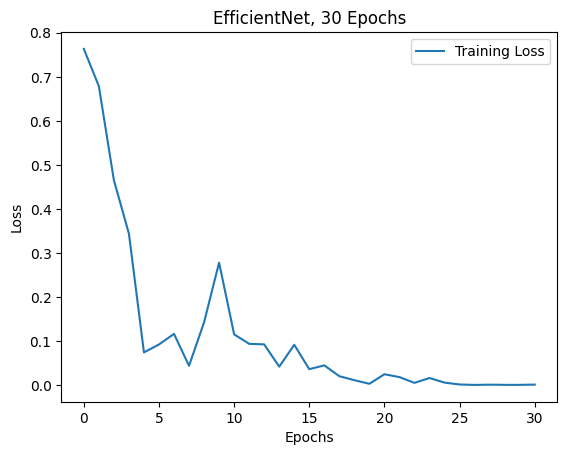

In [88]:
plt.plot([tensor.item() for tensor in tr_models[0].training_loss], label='Training Loss')
plt.title(f'EfficientNet, {epoch_used} Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'EfficientNet, {epoch_used} Epochs')
plt.show()

In [89]:
temp_model = models.efficientnet_b0(pretrained=False)

model = nn.Sequential(*list(temp_model.children())[:-1])
model.add_module('global_avg_pool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(temp_model.classifier[-1].in_features, 3))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [90]:
pl_model = tr_models[0]
loaded_model = load_model_checkpoint(model, f'effnet_epoch_{epoch_used}_weight.pth')

for mod in [pl_model, loaded_model]:
    predicted_labels = []
    true_labels = []

    mod.eval()
    mod.to(device)

    correct = 0
    total = 0

    print('=====')
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mod(inputs)
            # print(F.softmax(outputs, dim=1))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print(f'Predicted {predicted}, Labels {labels}')

            # Append predicted and true labels to the lists
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate and print the classification report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, zero_division=0))

=====
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.17      0.25      0.20         4
           2       0.33      0.33      0.33         3

    accuracy                           0.20        10
   macro avg       0.17      0.19      0.18        10
weighted avg       0.17      0.20      0.18        10

=====
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.17      0.25      0.20         4
           2       0.33      0.33      0.33         3

    accuracy                           0.20        10
   macro avg       0.17      0.19      0.18        10
weighted avg       0.17      0.20      0.18        10



### MobileNetV2

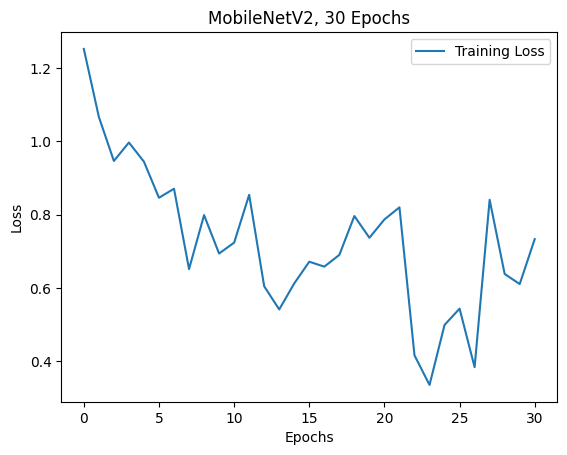

In [91]:
plt.plot([tensor.item() for tensor in tr_models[1].training_loss], label='Training Loss')
plt.title(f'MobileNetV2, {epoch_used} Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'MobileNetV2, {epoch_used} Epochs')
plt.show()

In [92]:
temp_model = models.mobilenet_v2(pretrained=False)

model = nn.Sequential(*list(temp_model.children())[:-1])
model.add_module('global_avg_pool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(temp_model.classifier[-1].in_features, 3))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [93]:
pl_model = tr_models[1]
loaded_model = load_model_checkpoint(model, f'mobilenet_epoch_{epoch_used}_weight.pth')

for mod in [pl_model, loaded_model]:
    predicted_labels = []
    true_labels = []

    mod.eval()
    mod.to(device)

    correct = 0
    total = 0

    print('=====')
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mod(inputs)
            # print(F.softmax(outputs, dim=1))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print(f'Predicted {predicted}, Labels {labels}')

            # Append predicted and true labels to the lists
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate and print the classification report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, zero_division=0))

=====
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.44      1.00      0.62         4
           2       0.00      0.00      0.00         3

    accuracy                           0.40        10
   macro avg       0.15      0.33      0.21        10
weighted avg       0.18      0.40      0.25        10

=====
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.44      1.00      0.62         4
           2       0.00      0.00      0.00         3

    accuracy                           0.40        10
   macro avg       0.15      0.33      0.21        10
weighted avg       0.18      0.40      0.25        10



### ShuffleNetV2

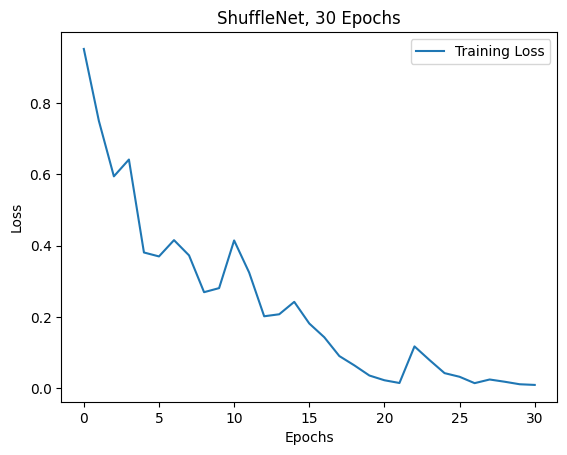

In [94]:
plt.plot([tensor.item() for tensor in tr_models[2].training_loss], label='Training Loss')
plt.title(f'ShuffleNet, {epoch_used} Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'ShuffleNet, {epoch_used} Epochs')
plt.show()

In [95]:
temp_model = models.shufflenet_v2_x1_0(pretrained=False)

model = nn.Sequential(*list(temp_model.children())[:-1])
model.add_module('global_avg_pool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(temp_model.fc.in_features, 3))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [96]:
pl_model = tr_models[2]
loaded_model = load_model_checkpoint(model, f'shufflenet_epoch_{epoch_used}_weight.pth')

for mod in [pl_model, loaded_model]:
    predicted_labels = []
    true_labels = []

    mod.eval()
    mod.to(device)

    correct = 0
    total = 0

    print('=====')
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mod(inputs)
            # print(F.softmax(outputs, dim=1))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print(f'Predicted {predicted}, Labels {labels}')

            # Append predicted and true labels to the lists
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate and print the classification report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, zero_division=0))

=====
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.29      0.50      0.36         4
           2       0.33      0.33      0.33         3

    accuracy                           0.30        10
   macro avg       0.21      0.28      0.23        10
weighted avg       0.21      0.30      0.25        10

=====
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.29      0.50      0.36         4
           2       0.33      0.33      0.33         3

    accuracy                           0.30        10
   macro avg       0.21      0.28      0.23        10
weighted avg       0.21      0.30      0.25        10



# Inference

In [23]:
for mod in sym_models:
    mod.eval()
    mod.to(device)

In [30]:
test_image_path = '../../dataset/v1/tampak_depan/hiqmatul.jpg'

test_image = Image.open(test_image_path).convert("RGB")
transform = val_transform
test_image = transform(test_image).unsqueeze(0)
test_image = test_image.to(device)

In [25]:
with torch.no_grad():
    output = sym_models[0](test_image)
    _, predicted_class = torch.max(output, 1)
    pred_class = sym_task.encoding_dict[predicted_class.item()]
    print('EfficientNet')
    print('Simetris?', pred_class)

EfficientNet
Simetris? tidak


In [26]:
with torch.no_grad():
    output = sym_models[1](test_image)
    _, predicted_class = torch.max(output, 1)
    pred_class = sym_task.encoding_dict[predicted_class.item()]
    print('MobileNet')
    print('Simetris?', pred_class)

MobileNet
Simetris? ya


In [27]:
with torch.no_grad():
    output = sym_models[2](test_image)
    _, predicted_class = torch.max(output, 1)
    pred_class = sym_task.encoding_dict[predicted_class.item()]
    print('ShuffleNet')
    print('Simetris?', pred_class)

ShuffleNet
Simetris? tidak


In [28]:
def draw_face_bounding_box(image_path, pred_class):
    image = cv2.imread(image_path)
    face_cascade = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(
            image
            , pred_class
            , (x, y-10)
            , cv2.FONT_HERSHEY_SIMPLEX
            , 0.5 # Font size.
            , (255, 255, 255) # Text color
        )
        
    # cv2.imshow('Face Detection', image)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    display(image_pil)

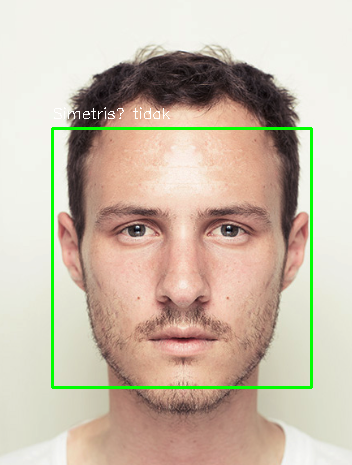

In [29]:
draw_face_bounding_box(test_image_path, f'Simetris? {pred_class}')